# Neighbor preference quantification

In [1]:
# Run this cell when making changes to editable packages
# e.g., utils
%load_ext autoreload
%autoreload 2

In [ ]:
## Imports
import scimap as sm
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
import time
import sys
from pathlib import Path
from scripts.utils.data_loading import *
from scripts.utils.plotting.neighbor_preference import *

# Import COZI from git submodules
COZI_path = Path("../submodules/COZI/scimap/tools").resolve()
if str(COZI_path) not in sys.path:
    sys.path.append(str(COZI_path))
from spatial_interaction import spatial_interaction as COZI

In [3]:
## Load data
radius = 20
sections_2to3 = np.arange(10,150,10)

adata2 = load_data_2D()
adata3_min = load_data_3D_min(radius=radius, sections=sections_2to3)
adata3_full = load_data_3D_full()

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



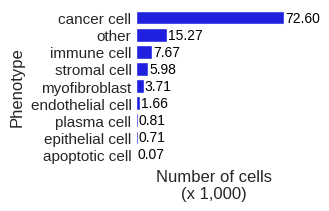

In [4]:
## Plot total cell type abundances
counts = pd.DataFrame({ 'n_cells': adata3_full.obs.groupby('ct_broad', observed=True).size() / 1000 })
counts.index.name = 'phenotype'
counts.sort_values('n_cells', ascending=False, inplace=True)

## Barplot with ('true') 3D counts
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.subplots(figsize=(2, 2))
    sns.barplot(x=counts['n_cells'], y=counts.index, order=counts.index, color='blue')
    plt.ylabel('Phenotype')
    plt.xlabel('Number of cells\n(x 1,000)')
    plt.xticks([], [])
    sns.despine(left=True, bottom=True)

    for idx, (index, row) in enumerate(counts.iterrows()):
        text = f'{(row["n_cells"]):.2f}'
        plt.text(
            (row['n_cells']) + 0.5,  # position text slightly to the right of the bar
            idx,                     # y-position is the index in the DataFrame
            text,
            va='center',
            ha='left',
            color="black",
            fontsize=10,
        )
    #plt.savefig('../../figures/ncells_phenotype_3Dfull.svg', bbox_inches='tight')
    plt.show()

## Testing observations from Kuett et al. (2022)

In [8]:
## Prepare data
def prepare_data_Kuett(adata, imageid_col, pattern, verbose=True):
    # Cave: All data outside obs will be lost

    df = adata.obs.copy()
    
    # Select phenotypes of interest
    if pattern == 'pattern1':
        df[pattern] = df['phenograph'].map({'13':'T cell','18':'T cell','21':'endothelial cell'}).fillna('other')
    elif pattern == 'pattern2':
        df[pattern] = df['phenograph'].map({'30':'subtype A','28':'subtype B'}).fillna('other')
    
    # Drop single entries (otherwise scimap error)
    single_entries = df.groupby([imageid_col, pattern], observed=False).filter(lambda x: len(x) == 1)
    if single_entries.shape[0] > 0:
        df = df.drop(single_entries.index)
        if verbose:
            print(f'Removed {single_entries.shape[0]} single entries from data (pattern: {pattern})')
    
    return ad.AnnData(obs=df)

adata2_p1 = prepare_data_Kuett(adata2, 'z', 'pattern1')
adata3_min_p1 = prepare_data_Kuett(adata3_min, 'section', 'pattern1')
adata3_full_p1 = prepare_data_Kuett(adata3_full, 'imageid', 'pattern1')

adata2_p2 = prepare_data_Kuett(adata2, 'z', 'pattern2')
adata3_min_p2 = prepare_data_Kuett(adata3_min, 'section', 'pattern2')
adata3_full_p2 = prepare_data_Kuett(adata3_full, 'imageid', 'pattern2')

Removed 8 single entries from data (pattern: pattern2)


### Run methods

In [15]:
## Scimap: Spatial interaction based on phenotypes from
# pattern1: T cells, endothelial cells
# pattern2: CD68+ subtype_A, subtype_B
kwargs = {'x_coordinate':'x', 'y_coordinate':'y', 'label':'spatial_interaction_scimap',
          'method':'radius', 'radius':radius, 'permutation':1000, 'pval_method':'zscore', 'verbose':False}

t0 = time.process_time()
sm.tl.spatial_interaction(adata2_p1, phenotype='pattern1', z_coordinate=None, imageid='z', **kwargs)
sm.tl.spatial_interaction(adata2_p2, phenotype='pattern2', z_coordinate=None, imageid='z', **kwargs)
print("Time elapsed for 2D: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

t0 = time.process_time()
sm.tl.spatial_interaction(adata3_min_p1, phenotype='pattern1', z_coordinate='z', imageid='section', **kwargs)
sm.tl.spatial_interaction(adata3_min_p2, phenotype='pattern2', z_coordinate='z', imageid='section', **kwargs)
print("Time elapsed for 3D minimal: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

t0 = time.process_time()
sm.tl.spatial_interaction(adata3_full_p1, phenotype='pattern1', z_coordinate='z', imageid='imageid', **kwargs)
sm.tl.spatial_interaction(adata3_full_p2, phenotype='pattern2', z_coordinate='z', imageid='imageid', **kwargs)
print("Time elapsed for 3D full: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))))

Time elapsed for 2D:  00:08:16
Time elapsed for 3D minimal:  00:28:06
Time elapsed for 3D full:  00:16:33


In [105]:
## COZI: Spatial interaction based on phenotypes from
# pattern1: T cells, endothelial cells
# pattern2: CD68+ subtype_A, subtype_B
kwargs = {'x_coordinate':'x', 'y_coordinate':'y', 'label':'spatial_interaction_COZI',
         'method':'radius', 'radius':radius, 'permutation':1000, 'pval_method':'zscore', 'normalization':'conditional', 'verbose':False}

t0 = time.process_time()
COZI(adata2_p1, z_coordinate=None, phenotype='pattern1', imageid='z', **kwargs)
COZI(adata2_p2, z_coordinate=None, phenotype='pattern2', imageid='z', **kwargs)
print("Time elapsed for 2D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

t0 = time.process_time()
COZI(adata3_min_p1, z_coordinate='z', phenotype='pattern1', imageid='section', **kwargs)
COZI(adata3_min_p2, z_coordinate='z', phenotype='pattern2', imageid='section', **kwargs)
print("Time elapsed for 3D minimal: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

t0 = time.process_time()
COZI(adata3_full_p1, z_coordinate='z', phenotype='pattern1', imageid='imageid', **kwargs)
COZI(adata3_full_p2, z_coordinate='z', phenotype='pattern2', imageid='imageid', **kwargs)
print("Time elapsed for 3D full data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

Time elapsed for 2D data:  00:09:17
Time elapsed for 3D minimal:  00:42:16
Time elapsed for 3D full data:  00:15:55


In [106]:
## Save results
for method in ['scimap', 'COZI']:
    adata2_p1.uns[f'spatial_interaction_{method}'].to_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_2D_r{radius}_pattern1.csv')
    adata3_min_p1.uns[f'spatial_interaction_{method}'].to_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_min_r{radius}_pattern1.csv')
    adata3_full_p1.uns[f'spatial_interaction_{method}'].to_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_full_r{radius}_pattern1.csv')

    adata2_p2.uns[f'spatial_interaction_{method}'].to_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_2D_r{radius}_pattern2.csv')
    adata3_min_p2.uns[f'spatial_interaction_{method}'].to_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_min_r{radius}_pattern2.csv')
    adata3_full_p2.uns[f'spatial_interaction_{method}'].to_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_full_r{radius}_pattern2.csv')

### Assess results

In [9]:
## Load results
for method in ['scimap', 'COZI']:
    adata2_p1.uns[f'spatial_interaction_{method}'] = pd.read_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_2D_r{radius}_pattern1.csv', index_col=0)
    adata3_min_p1.uns[f'spatial_interaction_{method}'] = pd.read_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_min_r{radius}_pattern1.csv', index_col=0)
    adata3_full_p1.uns[f'spatial_interaction_{method}'] = pd.read_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_full_r{radius}_pattern1.csv', index_col=0)

    adata2_p2.uns[f'spatial_interaction_{method}'] = pd.read_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_2D_r{radius}_pattern2.csv', index_col=0)
    adata3_min_p2.uns[f'spatial_interaction_{method}'] = pd.read_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_min_r{radius}_pattern2.csv', index_col=0)
    adata3_full_p2.uns[f'spatial_interaction_{method}'] = pd.read_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_full_r{radius}_pattern2.csv', index_col=0)

In [131]:
## Scale COZI scores (see below)
for adata in [adata2_p1, adata2_p2]:
    zscore_cols = adata2_p1.uns['spatial_interaction_COZI'].columns.str.startswith('zscore')
    adata2_p1.uns['spatial_interaction_COZI'].loc[:, zscore_cols] = adata2_p1.uns['spatial_interaction_COZI'].loc[:, zscore_cols] * (2**1.4)

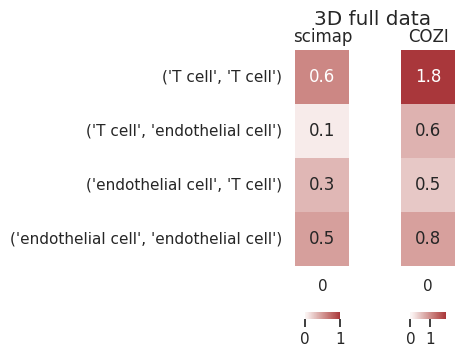

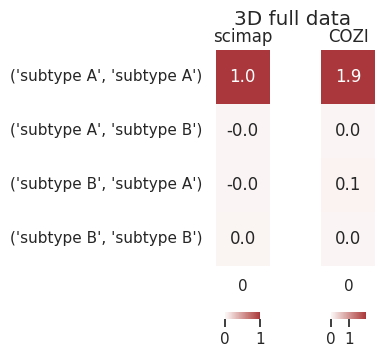

In [10]:
## Plot NEP scores for interactions involving cell types of interest
def prep_data(df, method, row_index):
    df = df[ (df['phenotype']!='other') & (df['neighbour_phenotype']!='other') ]
    df = df.set_index(['phenotype', 'neighbour_phenotype'])
    if method == 'scimap':
        df = df.loc[ row_index, 'imageid']
    if method == 'COZI':
        df = df.loc[ row_index, 'zscore_imageid']
    return df.values[:, np.newaxis]

for i, adata in enumerate([adata3_full_p1.copy(), adata3_full_p2.copy()]):
    row_index = [ i for i in adata.uns[f'spatial_interaction_scimap'].set_index(['phenotype', 'neighbour_phenotype']).index if (i[0]!='other') & (i[1]!='other') ] 
    
    df_sm = prep_data(adata.uns[f'spatial_interaction_scimap'], 'scimap', row_index)
    df_COZI = prep_data(adata.uns[f'spatial_interaction_COZI'], 'COZI', row_index)

    fig, ax = plt.subplots(1, 2, figsize=(2.5,4), sharey=True)
    fig.suptitle('3D full data')
    kwargs = {'cmap':'vlag', 'center':0, 'square':True, 'annot':True, 'fmt':'.1f'}
    cbar_kws = {'shrink':.4, 'aspect':5, 'location':'bottom', 'ticklocation':'bottom'}
    
    sns.heatmap(df_sm, ax=ax[0], **kwargs, 
                vmin=(0 if df_sm.min() >= -.04 else -1), 
                vmax=(0 if df_sm.max() <= .04 else 1),
                cbar=True, cbar_kws=cbar_kws)
    sns.heatmap(df_COZI, ax=ax[1], **kwargs, 
                vmin=(0 if df_COZI.min() > 0 else df_COZI.min()), # scimap has no inherent max or min
                vmax=(0 if df_COZI.max() < 0 else df_COZI.max()),
                cbar=True, cbar_kws=cbar_kws)
    
    ax[0].set_title('scimap')
    ax[1].set_title('COZI')
    ax[0].set_yticklabels(row_index, rotation=0)
    
    #plt.savefig(f'../../figures/coloc_pattern{i+1}_3D_full_rowwise.svg', bbox_inches='tight')
    plt.show()

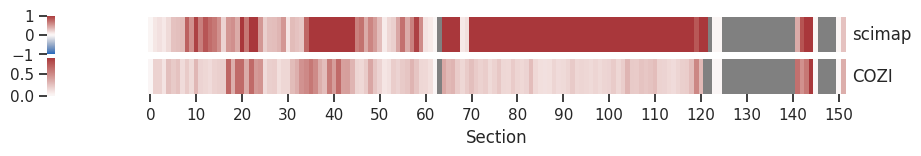

In [ ]:
## Plot 2D scores along z
interaction = ['subtype A','subtype A']

fig, ax = plt.subplots(2,1, figsize=(12,1))
cmap = plt.get_cmap('vlag')
cmap.set_bad('grey')

for i, method in enumerate(['scimap','COZI']):
    if method=='scimap':
        scores = adata2_p2.uns[f'spatial_interaction_{method}'].set_index(['phenotype', 'neighbour_phenotype']).loc[tuple(interaction), np.arange(0,152).astype(str)] 
        kwargs = {'vmin':-1, 'vmax':1}   
    else:
        scores = adata2_p2.uns[f'spatial_interaction_{method}'].set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore', axis=1).loc[tuple(interaction), :]
        kwargs= {}
    scores[ np.isinf(scores) ] = np.nan
    sns.heatmap(pd.DataFrame(scores).T, ax=ax[i],
                mask=np.isnan(scores.values)[np.newaxis, :], 
                cmap=cmap, annot=False, center=0, **kwargs,
                xticklabels=10,
                cbar_kws={'shrink':1.1, 'aspect':5, 'location':'left', 'ticklocation':'right'} )
    ax[i].set_yticks([],[])
    ax[i].set_ylabel(None)
    ax[i].text(1.01, .5, method, transform=ax[i].transAxes, rotation=0, va='center')
ax[0].set_xticklabels([])
ax[1].set_xticklabels(np.arange(0,152,10), rotation=0)
ax[1].xaxis.tick_bottom() # visible ticks
ax[1].set_xlabel('Section')
plt.show()

scimap, endothelial cell <> T cell


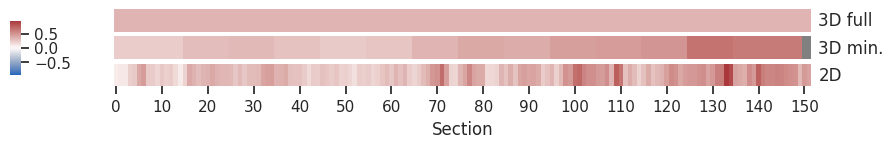

COZI, endothelial cell <> T cell


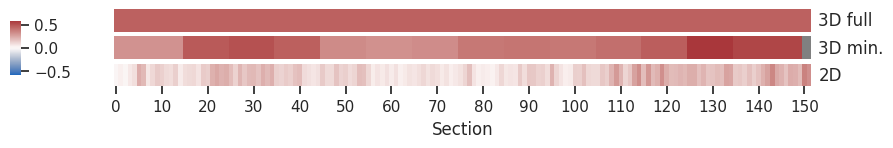

In [18]:
# Plot pattern2 along z
for method in ['scimap', 'COZI']:
    plot_alongZ(
        adata3_full_p1.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        adata3_min_p1.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        adata2_p1.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        interaction=('endothelial cell','T cell'),
        method=method,
        #savefig=f'../../figures/coloc_pattern_{interaction[0]}_{interaction[1]}_{method}.svg'
        )

scimap, subtype A <> subtype A


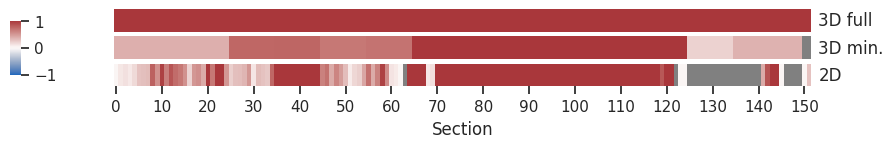

COZI, subtype A <> subtype A


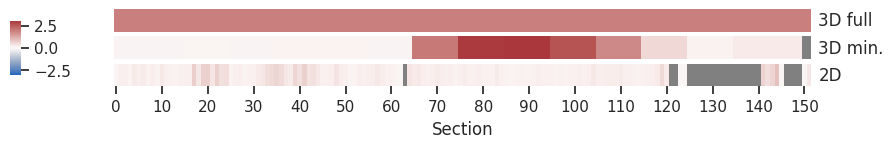

In [19]:
## Plot pattern2 along z
for method in ['scimap', 'COZI']:
    plot_alongZ(
        adata3_full_p2.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        adata3_min_p2.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        adata2_p2.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        interaction=('subtype A','subtype A'),
        method=method,
        #savefig=f'../../figures/coloc_pattern_{interaction[0]}_{interaction[1]}_{method}.svg'
        )

## Neighbor preference between all phenotypes

### Run methods

In [20]:
## In sections with only one cell per phenotype, remove that cell
# to avoid error in scimap function (issue opened)
# This is not ideal, as it changes the 2D, but not 3D data
single_entries = adata2.obs.groupby(['z', 'ct_broad']).filter(lambda x: len(x) == 1)
adata2 = adata2[ ~adata2.obs.index.isin(single_entries.index) ]
print(f'Removed {single_entries.shape[0]} single entries from 2D data')

Removed 41 single entries from 2D data


/tmp/ipykernel_60702/1528632209.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
## Scimap: Spatial interaction based on phenotypes from ct_broad
kwargs = {'x_coordinate':'x', 'y_coordinate':'y', 'phenotype':'ct_broad', 'label':'spatial_interaction_scimap',
          'method':'radius', 'radius':radius, 'permutation':1000, 'pval_method':'zscore', 'verbose':False}

t0 = time.process_time()
sm.tl.spatial_interaction(adata2, z_coordinate=None, imageid='z', **kwargs)
print("Time elapsed for 2D: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

t0 = time.process_time()
sm.tl.spatial_interaction(adata3_min, z_coordinate='z', imageid='section', **kwargs)
print("Time elapsed for 3D minimal: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

t0 = time.process_time()
sm.tl.spatial_interaction(adata3_full, z_coordinate='z', imageid='imageid', **kwargs)
print("Time elapsed for 3D full: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

In [59]:
## COZI: Spatial interaction based on phenotypes from ct_broad
kwargs = {'x_coordinate':'x', 'y_coordinate':'y', 'phenotype':'ct_broad', 'label':'spatial_interaction_COZI',
         'method':'radius', 'radius':radius, 'permutation':1000, 'pval_method':'zscore', 'normalization':'conditional', 'verbose':False}
t0 = time.process_time()
COZI(adata2, z_coordinate=None, imageid='z', **kwargs)
print("Time elapsed for 2D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0)) ))

t0 = time.process_time()
COZI(adata3_min, z_coordinate='z', imageid='section', **kwargs)
print("Time elapsed for 3D minimal: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0)) ))

t0 = time.process_time()
COZI(adata3_full, z_coordinate='z', imageid='imageid', **kwargs)
print("Time elapsed for 3D full data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0)) ))

Time elapsed for 2D data:  00:00:00
Time elapsed for 3D minimal:  00:13:31
Time elapsed for 3D full data:  00:07:43


In [60]:
## Save results
for method in ['scimap','COZI']:
    adata2.uns[f'spatial_interaction_{method}'].to_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_2D.csv', sep=',', index=False)
    adata3_min.uns[f'spatial_interaction_{method}'].to_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_min.csv', sep=',', index=False)
    adata3_full.uns[f'spatial_interaction_{method}'].to_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_full.csv', sep=',', index=False)

### Assess results

In [21]:
## Load results
for method in ['scimap','COZI']:
    adata2.uns[f'spatial_interaction_{method}'] = pd.read_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_2D.csv')
    adata3_min.uns[f'spatial_interaction_{method}'] = pd.read_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_min.csv')
    adata3_full.uns[f'spatial_interaction_{method}'] = pd.read_csv(f'../../data/temp/Kuett_2022_spatial_interaction_{method}_3D_full.csv')

/tmp/ipykernel_60702/345317069.py:3: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



The range of COZI results is affected by two parameters: the number of cells per image, and the number of cells in the neighborhood. The first parameter was adjusted for by dividing the z-scores by the square root of the number of cells per image. The resulting distribution of scores looks like this:

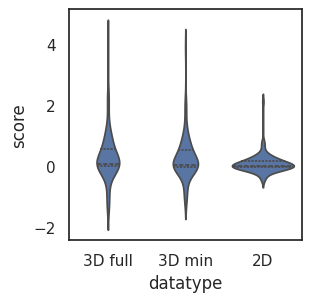

In [22]:
# Get z-scores
scores_3m = adata3_min.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).filter(like='zscore', axis=1).copy()
scores_2 = adata2.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).filter(like='zscore', axis=1)

coloc = pd.DataFrame({
    'score': np.concatenate([adata3_full.uns['spatial_interaction_COZI']['zscore_imageid'].values,
                             scores_3m.apply(lambda x: np.nanmean(x), 1),
                             scores_2.apply(lambda x: np.nanmean(x), 1)]),
    'datatype': np.repeat(['3D full', '3D min', '2D'], scores_3m.shape[0])  })

# Plot
fig, ax = plt.subplots(figsize=(3,3))
sns.violinplot(data=coloc, x='datatype', y='score', inner='quartile')
plt.show()

The range of 2D scores is smaller due to the lower number of cells in the neighborhood. We can scale the z-scores accordingly, based on the results on the NBH size. Note that we will only scale the z-scores here, not the counts, as all further plots do not use them.

In [23]:
# Scale COZI scores for 2D data
zscore_cols = adata2.uns['spatial_interaction_COZI'].columns.str.startswith('zscore')
adata2.uns['spatial_interaction_COZI'].loc[:, zscore_cols] = adata2.uns['spatial_interaction_COZI'].loc[:, zscore_cols] * (2**1.4)

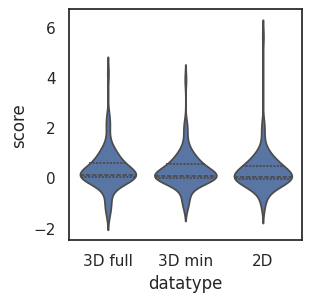

In [24]:
# Plot new results
scores_2 = adata2.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).filter(like='zscore', axis=1)
coloc = pd.DataFrame({
    'score': np.concatenate([adata3_full.uns['spatial_interaction_COZI']['zscore_imageid'].values,
                             scores_3m.apply(lambda x: np.nanmean(x), 1),
                             scores_2.apply(lambda x: np.nanmean(x), 1)]),
    'datatype': np.repeat(['3D full', '3D min', '2D'], scores_3m.shape[0])  })

fig, ax = plt.subplots(figsize=(3,3))
sns.violinplot(data=coloc, x='datatype', y='score', inner='quartile')
plt.show()

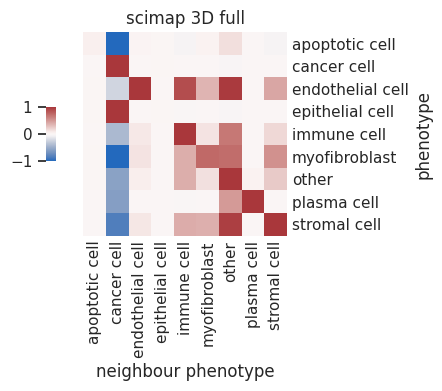

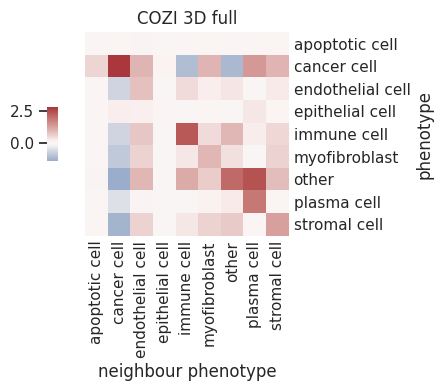

In [25]:
## 3D full data
spatial_interaction_plot_mean(adata3_full.uns[f'spatial_interaction_scimap'], method='scimap', title='scimap 3D full', 
                             figsize=(3.5,3.5), kwargs={'annot':False},
                             #savefig='../../figures/coloc_scimap_3D_full.svg'
                             )
spatial_interaction_plot_mean(adata3_full.uns[f'spatial_interaction_COZI'], method='COZI', title='COZI 3D full', 
                             figsize=(3.5,3.5), kwargs={'vmax':2.8, 'annot':False},
                             #savefig='../../figures/coloc_COZI_3D_full.svg'
                             )

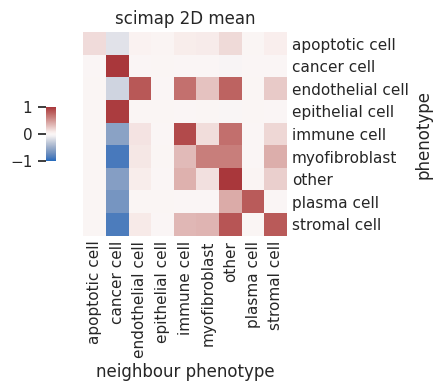

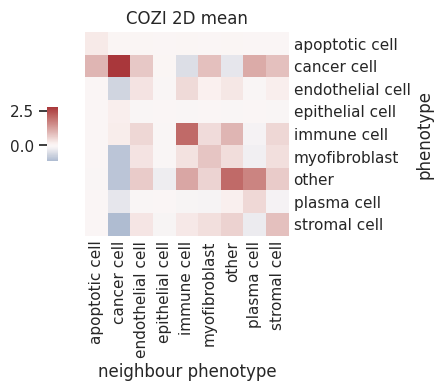

In [26]:
## 2D data
spatial_interaction_plot_mean(adata2.uns[f'spatial_interaction_scimap'], method='scimap', title='scimap 2D mean', 
                             figsize=(3.5,3.5), kwargs={'annot':False}) #, savefig='../../figures/spatial_interaction_scimap_2D.svg')
spatial_interaction_plot_mean(adata2.uns[f'spatial_interaction_COZI'], method='COZI', title='COZI 2D mean', 
                             figsize=(3.5,3.5), kwargs={'vmax':2.8, 'annot':False}) #, savefig='../../figures/spatial_interaction_COZI_2D.svg')

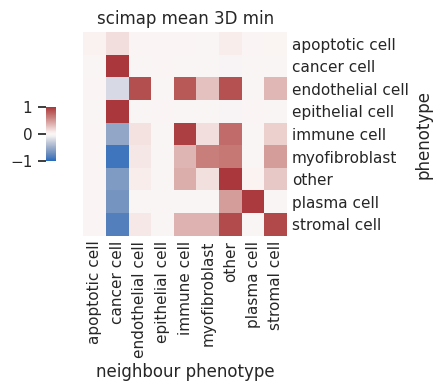

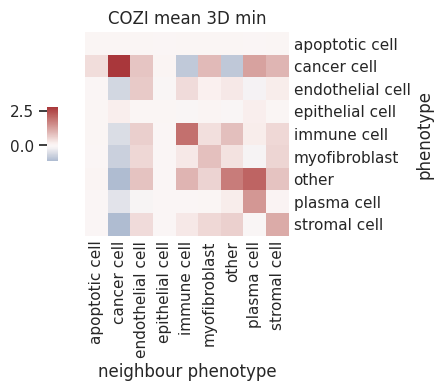

In [27]:
## 3D min data
spatial_interaction_plot_mean(adata3_min.uns[f'spatial_interaction_scimap'], method='scimap', title='scimap mean 3D min', 
                             figsize=(3.5,3.5), kwargs={'annot':False}) #, savefig='../../figures/spatial_interaction_scimap_3D_min.svg')
spatial_interaction_plot_mean(adata3_min.uns[f'spatial_interaction_COZI'], method='COZI', title='COZI mean 3D min', 
                             figsize=(3.5,3.5), kwargs={'vmax':2.8, 'annot':False}) #, savefig='../../figures/spatial_interaction_COZI_3D_min.svg')

scimap, immune cell <> cancer cell


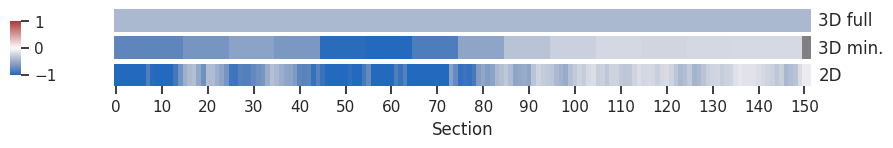

COZI, immune cell <> cancer cell


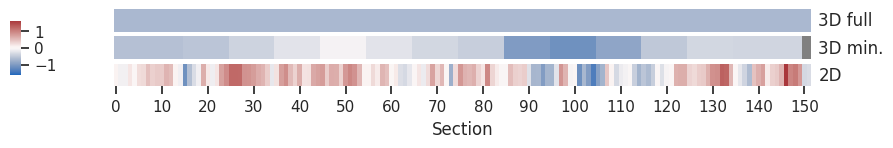

In [33]:
## Plot along z
interaction = ('immune cell', 'cancer cell')
for method in ['scimap', 'COZI']:
    plot_alongZ(
        adata3_full.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        adata3_min.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        adata2.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        interaction=interaction,
        method=method,
        #savefig=f'../../figures/coloc_{interaction[0]}_{interaction[1]}_{method}.svg'
        )

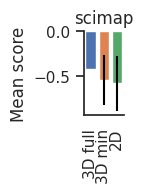

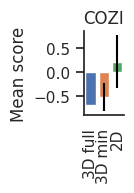

In [34]:
# Plot mean scores per dimensionality and method
for method in ['scimap', 'COZI']:
    if method == 'scimap':
        score_3Df = adata3_full.uns['spatial_interaction_scimap'].set_index(['phenotype','neighbour_phenotype']).loc[:, 'imageid']
        try:
            score_3Dm = adata3_min.uns['spatial_interaction_scimap'].set_index(['phenotype','neighbour_phenotype']).loc[:, sections_2to3]
            score_2D = adata2.uns['spatial_interaction_scimap'].set_index(['phenotype','neighbour_phenotype']).loc[:, np.arange(152)]
        except KeyError:
            score_3Dm = adata3_min.uns['spatial_interaction_scimap'].set_index(['phenotype','neighbour_phenotype']).loc[:, sections_2to3.astype(str)]
            score_2D = adata2.uns['spatial_interaction_scimap'].set_index(['phenotype','neighbour_phenotype']).loc[:, np.arange(152).astype(str)]
    if method == 'COZI':
        score_3Df = adata3_full.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).loc[:, 'zscore_imageid']
        score_2D = adata2.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).filter(like='zscore', axis=1)
        score_3Dm = adata3_min.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).filter(like='zscore', axis=1)
    
    score_3Dm[ np.isinf(score_3Dm) ] = np.nan
    score_2D[ np.isinf(score_2D) ] = np.nan

    fig, ax = plt.subplots(figsize=(1.5,2.1), layout='tight')
    for i, score in enumerate([score_3Df, score_3Dm, score_2D]):
        if i == 0:
            smean = score[interaction]
            ssdev = 0
        else:
            smean = np.nanmean(score.loc[interaction, :])
            ssdev = np.nanstd(score.loc[interaction, :])
        ax.bar(i, smean)
        ax.errorbar(i, smean, yerr=ssdev, color='black')
        ax.set_title(method)
    ax.set_xticks(np.arange(3), ['3D full', '3D min', '2D'], rotation=90)
    ax.tick_params(axis='y', left=True)
    ax.set_ylabel('Mean score')
    sns.despine(top=True, right=True)

    #plt.savefig(f'../../figures/coloc_{interaction[0]}_{interaction[1]}_{method}_means.svg')
    plt.show()

The mean score over all 2D sections does not approximate the 3D full score well, but 2D scores do not seem to be systematically biased (higher/lower):

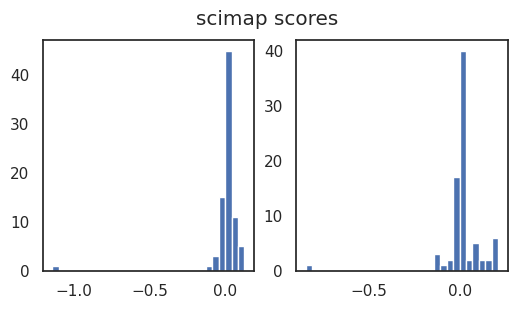

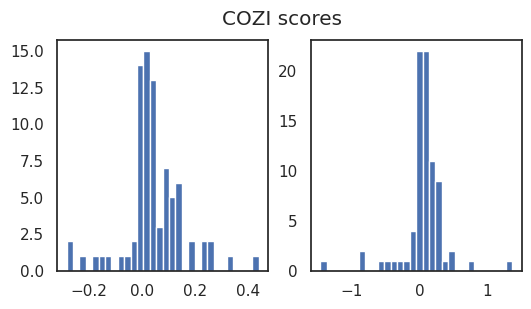

In [35]:
## Is there a bias between 3D full and mean data?
for method in ['scimap', 'COZI']:
    if method=='scimap':
        score_3Df = adata3_full.uns['spatial_interaction_scimap'].set_index(['phenotype','neighbour_phenotype']).loc[:, 'imageid']
        score_3Dm = adata3_min.uns['spatial_interaction_scimap'].set_index(['phenotype','neighbour_phenotype']).loc[:, sections_2to3.astype(str)]
        score_2D = adata2.uns['spatial_interaction_scimap'].set_index(['phenotype','neighbour_phenotype']).loc[:, np.arange(152).astype(str)]
    else:
        score_3Df = adata3_full.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).loc[:, 'zscore_imageid']
        score_3Dm = adata3_min.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).filter(like='zscore', axis=1)
        score_2D = adata2.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).filter(like='zscore', axis=1)
        
    score_3Dm[ np.isinf(score_3Dm) ] = np.nan
    score_2D[ np.isinf(score_2D) ] = np.nan

    scores = pd.DataFrame(score_3Df)
    scores.columns = ['3D full']
    scores['3D min'] = pd.Series( np.nanmean( score_3Dm , 1), index= score_3Dm.index )
    scores['2D'] = pd.Series( np.nanmean( score_2D , 1), index= score_2D.index )

    fig, ax = plt.subplots(1,2, figsize=(6,3))
    fig.suptitle(f'{method} scores')
    for k, (i, j) in enumerate([['3D full', '3D min'], ['3D full', '2D']]):
        ax[k].hist(scores[i] - scores[j], bins=30)
    plt.show()

Scimap scores frequently correlate with cell type abundances:

scimap, immune cell <> endothelial cell


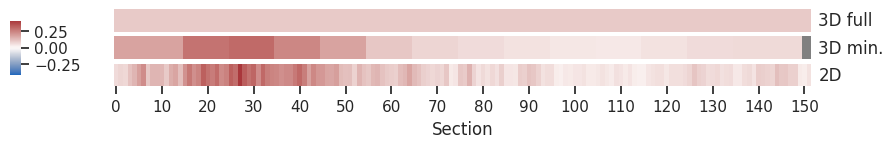

COZI, immune cell <> endothelial cell


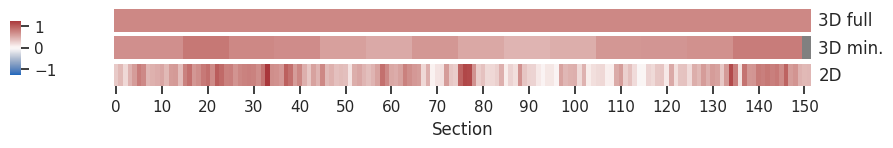

In [32]:
## Plot along z
interaction = ('immune cell', 'endothelial cell')
for method in ['scimap', 'COZI']:
    plot_alongZ(
        adata3_full.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        adata3_min.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        adata2.uns[f'spatial_interaction_{method}'].set_index(['phenotype','neighbour_phenotype']).copy(),
        interaction=interaction,
        method=method,
        #savefig=f'../../figures/coloc_{interaction[0]}_{interaction[1]}_{method}.svg'
        )

/tmp/ipykernel_60702/1379161815.py:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



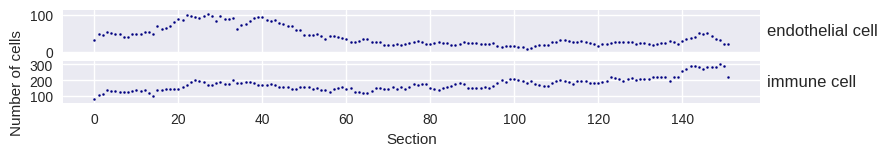

In [31]:
## Plot cell type abundances along z
counts = adata2[ np.isin(adata2.obs['ct_broad'].values, interaction) ].obs.groupby(['ct_broad', 'z'], observed=False).size().unstack().fillna(0)

n_types = counts.shape[0]
with plt.style.context('seaborn-v0_8'):
    fig, ax = plt.subplots(n_types, 1, figsize=(9, 1.2), sharex=True)
    for i, (idx, row) in enumerate(counts.iterrows()):
        ax[i].scatter(row.index, row, color='navy', s=2)
        range = row.max() - row.min()
        ax[i].set_ylim(row.min() - range * 0.1, row.max() + range * 0.1)
        ax[i].text(1.01, .4, f'{idx}', transform=ax[i].transAxes ) # Celltype label to the right
    ax[n_types//2].set_ylabel('Number of cells')
    ax[n_types-1].set_xlabel('Section')
    ax[n_types-1].set_xticklabels(ax[i].get_xticklabels(), rotation=0)
    #plt.savefig(f'../../figures/ncells_{interaction[0]}_{interaction[1]}_2D.svg', bbox_inches='tight')
    plt.show()

2.5D approach:

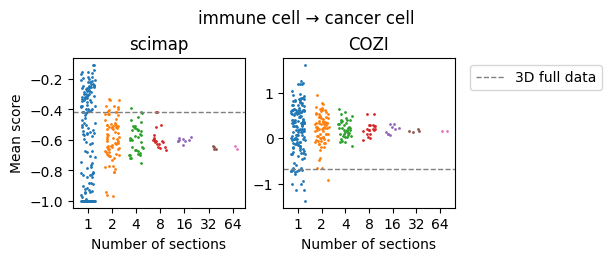

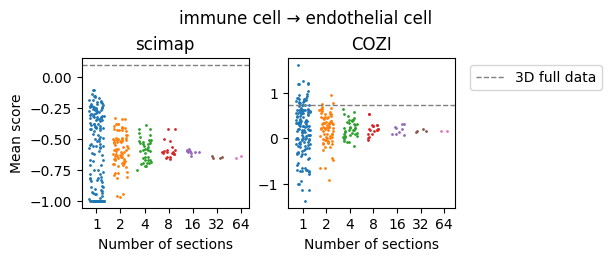

In [ ]:
## Does averaging the score of several regularly spaced 2D sections
# approximate the 3D full score?
interactions = [('immune cell', 'cancer cell'), ('immune cell', 'endothelial cell')]

total_sections = 2 ** np.arange(7)

# Prepare data
scores_scimap = adata2.uns['spatial_interaction_scimap'].set_index(
    ['phenotype','neighbour_phenotype']).loc[interaction, np.arange(0,152).astype(str)]
scores_scimap.index = scores_scimap.index.astype(int)
scores_scimap = scores_scimap[np.arange(0,152)] # sort
scores_COZI = adata2.uns['spatial_interaction_COZI'].set_index(
    ['phenotype','neighbour_phenotype']).filter(like='zscore', axis=1).loc[interaction, :]
scores_COZI.index = scores_COZI.index.str.split('_').str[1].astype(int)
scores_COZI = scores_COZI[np.arange(0,152)] # sort

# Select sections
mean_scores_scimap = {}
mean_scores_COZI = {}
for n_sections in total_sections:
    if n_sections == 1:
        mean_scores_scimap[n_sections] = scores_scimap.values
        mean_scores_COZI[n_sections] = scores_COZI.values
    step = 152 // n_sections
    results_scimap = np.empty(step)
    results_COZI = np.empty(step)
    for i in np.arange(step):
        sections = np.arange(i, n_sections*step, step)
        results_scimap[i] = np.nanmean( scores_scimap[sections] )
        results_COZI[i] = np.nanmean( scores_COZI[sections] )
    mean_scores_scimap[n_sections] = results_scimap
    mean_scores_COZI[n_sections] = results_COZI
mean_scores = { 'scimap': mean_scores_scimap, 'COZI': mean_scores_COZI }

# Stripplot
rng = np.random.default_rng(seed=42)
plt.style.use('default') # reset style

for interaction in interactions:
    fig, ax = plt.subplots(1,2, figsize=(6, 2.5), layout='constrained')
    fig.suptitle(f'{interaction[0]} → {interaction[1]}')
    for i, method in enumerate(['scimap', 'COZI']):
        # Mean of 2D section scores
        for j, n_sections in enumerate(total_sections):
            y = mean_scores[method][n_sections]
            x = np.repeat(j, len(y)) + rng.uniform(-.3, .3, len(y)) # with jitter
            ax[i].scatter(x, y, s=1)
        # 3D full score
        if method == 'scimap':
            score_3Df = adata3_full.uns['spatial_interaction_scimap'].set_index(
                ['phenotype','neighbour_phenotype']).loc[interaction, 'imageid']
        else:
            score_3Df = adata3_full.uns['spatial_interaction_COZI'].set_index(
                ['phenotype','neighbour_phenotype']).loc[interaction, 'zscore_imageid']
        ax[i].axhline(score_3Df, color='grey', linestyle='--', linewidth=1, label='3D full data')
        
        
        ax[i].set_xticks(np.arange(total_sections.size), total_sections)
        ax[i].set_title(method)
        ax[i].set_xlabel('Number of sections')
    ax[0].set_ylabel('Mean score')

    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    #plt.savefig(f'../../figures/coloc_{interaction[0]}_{interaction[1]}_{method}_evenly_spaced.svg')
    plt.show()

Explanation of COZI scores:
- COZI subsets cells of phenotype 0 (here: immune cells) by those with at least one cell of phenotype 1 (here: cancer cells)
- The NBH composition of these subset ('cond.') cells will thus contain more phenotype 1 cells than the average NBH of all phenotype 0 cells
- The COZI score does not correlate with the number of cells in the subset

In [44]:
## Choose sections & interaction pair
selection = [146, 73]
interaction = ('immune cell', 'cancer cell')

In [42]:
## Get z-scores (NEP)
nep = adata2.uns['spatial_interaction_COZI'].set_index(['phenotype','neighbour_phenotype']).filter(like='zscore', axis=1).loc[interaction, :]
nep.index = nep.index.str.replace('zscore_', '').astype(int)

In [46]:
## Get fraction of cancer cells in immune NBH
kwargs_count = { 'phenotype':'ct_broad', 'x_coordinate':'x', 'y_coordinate':'y', 'method':'radius', 'radius':radius, 'verbose':False }
sm.tl.spatial_count(adata2, z_coordinate=None, imageid='z', **kwargs_count)

mask = adata2.obs['z'].isin(selection) & (adata2.obs['ct_broad']=='immune cell')
fraction_cancer = adata2.uns['spatial_count'].loc[ mask, 'cancer cell']
fraction_cancer.index = adata2[ mask ].obs['id']

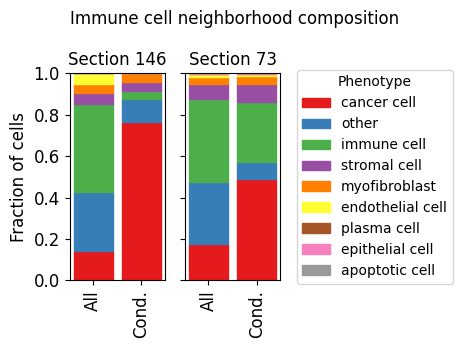

In [ ]:
## Immune cell NBH composition
fig, ax = plt.subplots(1,2, figsize=(4.8,3.5), layout='tight', sharey=True)

colors_phenotype = {
    'cancer cell': '#e41a1c',
    'other': '#377eb8',
    'immune cell': '#4daf4a',
    'stromal cell': '#984ea3',
    'myofibroblast': '#ff7f00',
    'endothelial cell': '#ffff33',
    'plasma cell': '#a65628',
    'epithelial cell': '#f781bf',
    'apoptotic cell': '#999999'
        }

for i, section in enumerate(selection):
    # Get mean NBH composition of immune cells (2D)
    filter = (adata2.obs['z']==section) & (adata2.obs['ct_broad']=='immune cell')
    comp_total = adata2.uns['spatial_count'].loc[ filter, : ].mean()
    comp_cond = adata2.uns['spatial_count'].loc[ filter & (adata2.uns['spatial_count']['cancer cell']>0), : ].mean() # at least one cancer cell in NBH
    
    for j, comp in enumerate([comp_total, comp_cond]):
        bottom = 0.
        for pt in colors_phenotype.keys():
            ax[i].bar(
                j, comp.loc[pt],
                bottom=bottom, label=pt, 
                facecolor=colors_phenotype[pt], edgecolor=colors_phenotype[pt])
            bottom += comp.loc[pt]
    
    fig.suptitle('Immune cell neighborhood composition')
    ax[i].set_title(f'Section {section}', size='large')
    ax[i].set_xticks(np.arange(2), ['All', 'Cond.'], rotation=90, size='large')
ax[0].set_ylabel('Fraction of cells', size='large')
ax[0].tick_params(axis='y', labelsize='large')
ax[1].legend(handles=[ mpatches.Patch(color=colors_phenotype[i], label=str(i)) for i in colors_phenotype.keys() ], # custom legend, otherwise redundant entries
            title='Phenotype', bbox_to_anchor=(1.1, 1.05), loc='upper left')

#plt.savefig('../../figures/nep_niches_scimap_pt_comp.svg', bbox_inches='tight')
plt.show()

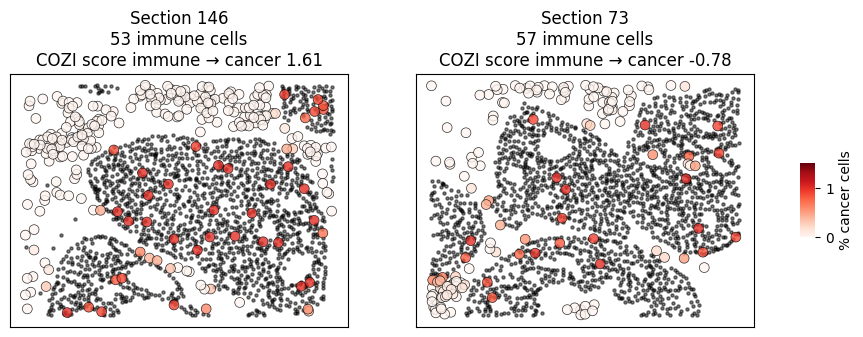

In [ ]:
## Spatial plot: immune cells and the fraction of cancer cells in their NBH
# Excluding all other cell types for clarity
fig, ax = plt.subplots(1,2, figsize=(12,12), sharey=True)

for i, section in enumerate(selection):
    ax[i].scatter(
        *adata2.obs.loc[ (adata2.obs['z']==section) & (adata2.obs['ct_broad']=='cancer cell'), ['x','y']].values.T,
        c='black', s=5, alpha=.5,
        label='cancer cell')
    filter_immune = (adata2.obs['z']==section) & (adata2.obs['ct_broad']=='immune cell')
    ax[i].scatter(
        *adata2.obs.loc[ filter_immune, ['x','y']].values.T,
        c = adata2.uns['spatial_count'].loc[ filter_immune, 'cancer cell' ],
        cmap='Reds', vmax=1.5,
        edgecolor='black', linewidths=.5,
        s=50, alpha=.8,
        label='immune cell')
    
    ax[i].set_title(f'Section {section}\n{n_cells.loc[section]} immune cells\nCOZI score immune → cancer {nep.loc[section]:.2f}')
    ax[i].set_aspect('equal', adjustable='box')
    ax[i].set_xticks([],[])
    ax[i].set_yticks([],[])

# Create colorbar
# note: max. possible fraction is 1, vmax set only to truncate color range
cmap = plt.get_cmap('Reds')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1.5))
sm.set_array([])
cbar_ax, _ = mpl.colorbar.make_axes(ax, location='right', shrink=.08, aspect=5)
cbar = fig.colorbar(sm, cax=cbar_ax, label='% cancer cells')
cbar.outline.set_visible(False)

#plt.savefig('../../figures/nep_niches_scimap_spatial_scatter.svg', bbox_inches='tight')
plt.show()

z
146    53
73     57
dtype: int64


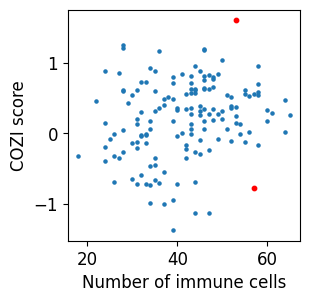

In [47]:
## NEP vs number of immune cells
n_cells = adata2[ (adata2.obs['ct_broad']=='immune cell') & (adata2.uns['spatial_count']['cancer cell']>0) ].obs.groupby('z', observed=False).size()
print(n_cells[selection])

plt.subplots(figsize=(3,3))
plt.scatter(n_cells.values, nep.loc[n_cells.index].values, s=5)
plt.scatter(n_cells[selection], nep.loc[selection].values, c='red', s=10)
plt.xlabel('Number of immune cells', size='large')
plt.ylabel('COZI score', size='large')
plt.tick_params(axis='both', labelsize='large')

#plt.savefig('../../figures/nep_niches_scimap_nep_vs_immune_cells.svg', bbox_inches='tight')
plt.show()

In [ ]:
## Save environment specs
!pip freeze > ../../environment/neighbor_preference.txt